In [29]:
%pip install xgboost lightgbm optuna


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score

# Data Visualization, Feature Selection

In [31]:
df = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

df.head()

,time_signature,speechiness,danceability,duration_ms,energy,track_href,mode,uri,type,track_album_release_date,analysis_url,id,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,Popularity_Type
0,4.0,0.2040,0.882,140733.0,0.764,https://api.spotify.com/v1/tracks/7iabz12vAuVQ...,1.0,spotify:track:7iabz12vAuVQYyekFIWJxD,audio_features,2024-05-23,https://api.spotify.com/v1/audio-analysis/7iab...,7iabz12vAuVQYyekFIWJxD,0.000000,0.886,11.0,140.113,-5.241,0.359000,0.1190,High
1,4.0,0.1590,0.779,246960.0,0.640,https://api.spotify.com/v1/tracks/4TsmezEQVSZN...,1.0,spotify:track:4TsmezEQVSZNNPv5RJ65Ov,audio_features,2005-08-29,https://api.spotify.com/v1/audio-analysis/4Tsm...,4TsmezEQVSZNNPv5RJ65Ov,0.000766,0.499,7.0,99.017,-8.415,0.000155,0.1010,High
2,4.0,0.2230,0.770,189707.0,0.597,https://api.spotify.com/v1/tracks/1AtFSBJibfaq...,1.0,spotify:track:1AtFSBJibfaqfiOByQCwZ5,audio_features,2024-06-21,https://api.spotify.com/v1/audio-analysis/1AtF...,1AtFSBJibfaqfiOByQCwZ5,0.000000,0.875,1.0,170.022,-4.901,0.530000,0.2390,High
3,5.0,0.3210,0.573,172296.0,0.693,https://api.spotify.com/v1/tracks/18Crh1Nd55lR...,1.0,spotify:track:18Crh1Nd55lRX4MVoJegO1,audio_features,2024-11-08,https://api.spotify.com/v1/audio-analysis/18Cr...,18Crh1Nd55lRX4MVoJegO1,0.004240,0.837,6.0,150.850,-6.220,0.609000,0.1960,Low
4,4.0,0.0315,0.714,274488.0,0.720,https://api.spotify.com/v1/tracks/42Xxh6RlXeZU...,1.0,spotify:track:42Xxh6RlXeZUNtNfbJ6A3D,audio_features,2020-12-24,https://api.spotify.com/v1/audio-analysis/42Xx...,42Xxh6RlXeZUNtNfbJ6A3D,0.000000,0.696,6.0,113.015,-6.751,0.092200,0.0742,Low


In [32]:
#feature engineer a more useful date column
df["track_album_release_date"] = pd.to_datetime(df["track_album_release_date"], errors='coerce')
df["song_age"] = datetime.now().year - df["track_album_release_date"].dt.year

#map popularity type to High -> 1 Low -> 0
df['Popularity_Type'] = df['Popularity_Type'].map({'High': 1, 'Low': 0})

#remove non numeric columns
df = df.drop(columns=["track_href", "uri", "analysis_url", "type", "track_album_release_date", "id"])

#remove na values
df.dropna(inplace=True)

df.head()

,time_signature,speechiness,danceability,duration_ms,energy,mode,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,Popularity_Type,song_age
0,4.0,0.2040,0.882,140733.0,0.764,1.0,0.000000,0.886,11.0,140.113,-5.241,0.359000,0.1190,1,1.0
1,4.0,0.1590,0.779,246960.0,0.640,1.0,0.000766,0.499,7.0,99.017,-8.415,0.000155,0.1010,1,20.0
2,4.0,0.2230,0.770,189707.0,0.597,1.0,0.000000,0.875,1.0,170.022,-4.901,0.530000,0.2390,1,1.0
3,5.0,0.3210,0.573,172296.0,0.693,1.0,0.004240,0.837,6.0,150.850,-6.220,0.609000,0.1960,0,1.0
4,4.0,0.0315,0.714,274488.0,0.720,1.0,0.000000,0.696,6.0,113.015,-6.751,0.092200,0.0742,0,5.0


In [33]:
# analyze relative importance of features

a=df[df["Popularity_Type"]==1] #popular
b=df[df["Popularity_Type"]==0] #not popular
a.describe()

,time_signature,speechiness,danceability,duration_ms,energy,mode,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,Popularity_Type,song_age
count,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.0,1292.000000
mean,3.952012,0.102752,0.657071,212187.649381,0.661441,0.583591,0.040720,0.519683,5.315789,120.715875,-6.716328,0.226184,0.170925,1.0,11.623839
std,0.313676,0.101088,0.157799,57647.774355,0.186327,0.493154,0.154865,0.237075,3.598472,26.887593,3.417753,0.250926,0.121663,0.0,13.199159
min,1.000000,0.023200,0.136000,61673.000000,0.001610,0.000000,0.000000,0.034800,0.000000,49.305000,-43.643000,0.000013,0.021000,1.0,1.000000
25%,4.000000,0.038400,0.551000,174609.250000,0.549000,0.000000,0.000000,0.330000,2.000000,100.020750,-7.885500,0.026550,0.094175,1.0,2.000000
50%,4.000000,0.058750,0.670000,210213.500000,0.683000,1.000000,0.000005,0.520500,5.000000,120.000000,-5.990000,0.136000,0.120000,1.0,6.000000
75%,4.000000,0.124000,0.774250,241749.250000,0.803000,1.000000,0.000642,0.716250,8.250000,136.928250,-4.682000,0.339000,0.210000,1.0,17.000000
max,5.000000,0.848000,0.979000,515387.000000,0.990000,1.000000,0.971000,0.978000,11.000000,204.028000,0.254000,0.995000,0.839000,1.0,71.000000


In [34]:
b.describe()

,time_signature,speechiness,danceability,duration_ms,energy,mode,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,Popularity_Type,song_age
count,2459.000000,2459.000000,2459.000000,2.459000e+03,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.0,2459.000000
mean,3.934526,0.101460,0.608096,2.019523e+05,0.543248,0.557950,0.288547,0.456869,5.131761,116.779250,-10.654044,0.405674,0.164064,0.0,5.559984
std,0.435628,0.100251,0.201733,9.354492e+04,0.264705,0.496731,0.394569,0.266492,3.559520,28.987447,8.130688,0.343493,0.123014,0.0,7.037269
min,1.000000,0.021900,0.059700,3.537500e+04,0.000202,0.000000,0.000000,0.029600,0.000000,48.232000,-48.069000,0.000004,0.022000,0.0,1.000000
25%,4.000000,0.039000,0.508000,1.510355e+05,0.350000,0.000000,0.000000,0.228000,2.000000,94.959000,-12.048500,0.084100,0.096550,0.0,1.000000
50%,4.000000,0.055400,0.652000,1.839900e+05,0.595000,1.000000,0.001430,0.461000,5.000000,116.130000,-8.015000,0.313000,0.116000,0.0,3.000000
75%,4.000000,0.117000,0.754000,2.256080e+05,0.746500,1.000000,0.788500,0.672000,8.000000,136.007500,-5.797500,0.732000,0.187500,0.0,6.000000
max,5.000000,0.927000,0.977000,1.241063e+06,0.996000,1.000000,0.991000,0.982000,11.000000,241.426000,1.075000,0.995000,0.979000,0.0,35.000000


                  Correlation       P-Value
song_age             0.287119  4.131992e-72
loudness             0.262421  4.063808e-60
energy               0.227366  3.508268e-45
danceability         0.123032  3.987718e-14
valence              0.115510  1.285692e-12
tempo                0.066015  5.205350e-05
duration_ms          0.058545  3.338639e-04
liveness             0.026600  1.033364e-01
mode                 0.024589  1.321511e-01
key                  0.024474  1.339669e-01
time_signature       0.020885  2.009616e-01
speechiness          0.006108  7.084221e-01
acousticness        -0.261647  9.214375e-60
instrumentalness    -0.334236  1.419923e-98


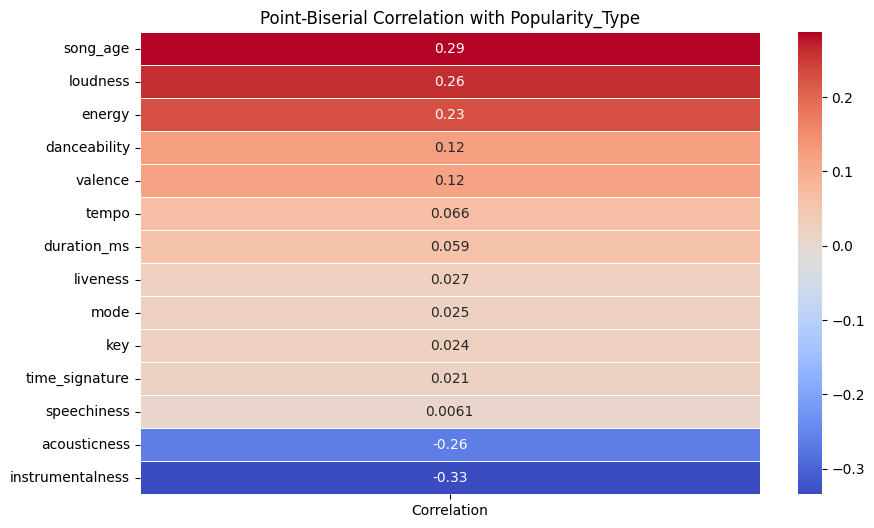

In [35]:
# Compute point-biserial correlation for each numeric feature
from scipy.stats import pointbiserialr

correlations = {}
for col in df.columns:
    if col != "Popularity_Type":  # Avoid self-correlation
        corr, p_value = pointbiserialr(df[col], df["Popularity_Type"])
        correlations[col] = (corr, p_value)

corr_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["Correlation", "P-Value"])
corr_df.sort_values(by="Correlation", ascending=False, inplace=True)

print(corr_df)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df[["Correlation"]], annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Point-Biserial Correlation with Popularity_Type")
plt.show()


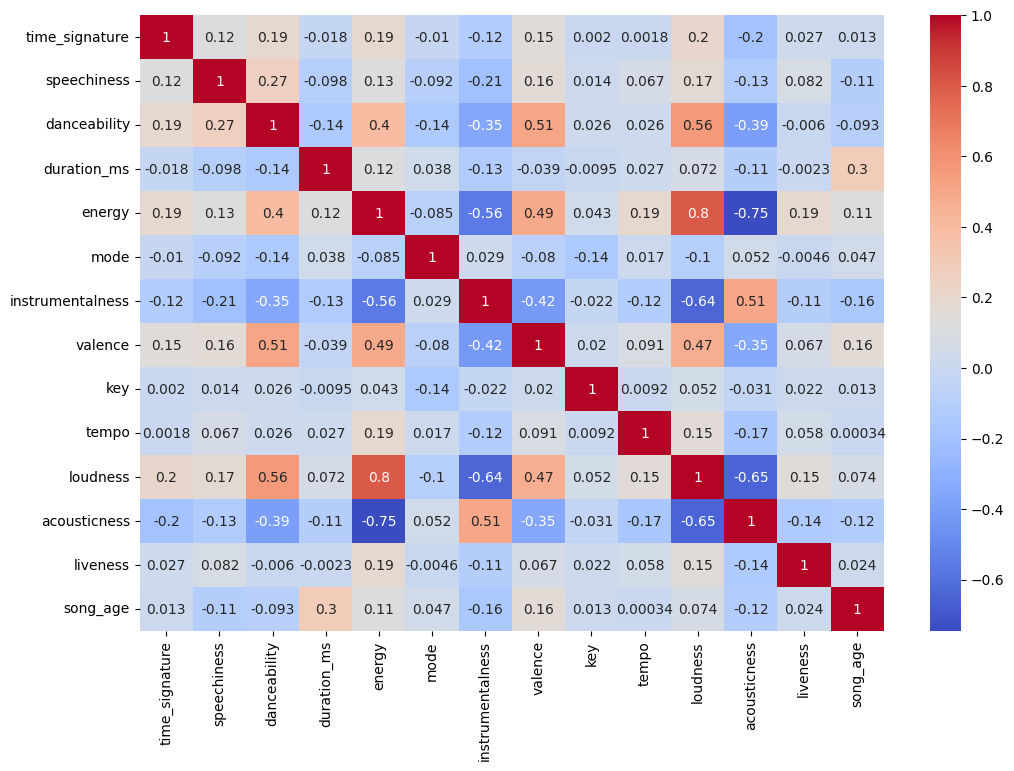

In [36]:
# visualize correlation of features
temp = df.drop(columns=["Popularity_Type"])

plt.figure(figsize=(12,8))
sns.heatmap(temp.corr(), cmap="coolwarm", annot=True)
plt.show()

In [37]:
# showing relavence of each value in feature "a" against popularity type, useful for categorical data 

a = "time_signature" #tried with key, mode, time_signature

df[[a,"Popularity_Type"]].groupby([a], as_index = False).mean().sort_values(by="Popularity_Type",ascending = False)

,time_signature,Popularity_Type
2,4.0,0.357057
1,3.0,0.271698
3,5.0,0.188034
0,1.0,0.160000


In [38]:
#one hot encode categorical data
df['key'] = df['key'].apply(lambda x: 1 if x >= 6 else 0)
df['time_signature'] = df['time_signature'].map({3: 0, 1: 0, 5: 1, 4: 1})

In [39]:
#final dataframe
df.head()

,time_signature,speechiness,danceability,duration_ms,energy,mode,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,Popularity_Type,song_age
0,1,0.2040,0.882,140733.0,0.764,1.0,0.000000,0.886,1,140.113,-5.241,0.359000,0.1190,1,1.0
1,1,0.1590,0.779,246960.0,0.640,1.0,0.000766,0.499,1,99.017,-8.415,0.000155,0.1010,1,20.0
2,1,0.2230,0.770,189707.0,0.597,1.0,0.000000,0.875,0,170.022,-4.901,0.530000,0.2390,1,1.0
3,1,0.3210,0.573,172296.0,0.693,1.0,0.004240,0.837,1,150.850,-6.220,0.609000,0.1960,0,1.0
4,1,0.0315,0.714,274488.0,0.720,1.0,0.000000,0.696,1,113.015,-6.751,0.092200,0.0742,0,5.0


# Model

In [40]:
#start from scratch
df = pd.read_csv('train.csv')

df["track_album_release_date"] = pd.to_datetime(df["track_album_release_date"], errors='coerce')
df["song_age"] = datetime.now().year - df["track_album_release_date"].dt.year
df = df.drop(columns=["track_href", "uri", "analysis_url", "type", "track_album_release_date"])
df = df.drop(columns=["id"])
df.dropna(inplace=True)
df['Popularity_Type'] = df['Popularity_Type'].map({'High': 1, 'Low': 0})
df['key'] = df['key'].apply(lambda x: 1 if x >= 6 else 0)
df['time_signature'] = df['time_signature'].map({3: 0, 1: 0, 5: 1, 4: 1})

X = df.drop(columns=["Popularity_Type"])
y = df["Popularity_Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

#run with hyperparameters found from optuna below
model = xgb.XGBClassifier(
    learning_rate=0.005814638231036287,
    n_estimators=714,
    max_depth=14,
    eval_metric="auc",
    gamma=0.2637438262778269,
    subsample=0.5018040242965975,
    colsample_bytree=0.7377318659882042,
    reg_alpha=0.3218825329154986,
    reg_lambda=0.0023265825915590346,

)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred_proba_high = y_pred_proba[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba_high)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.7832


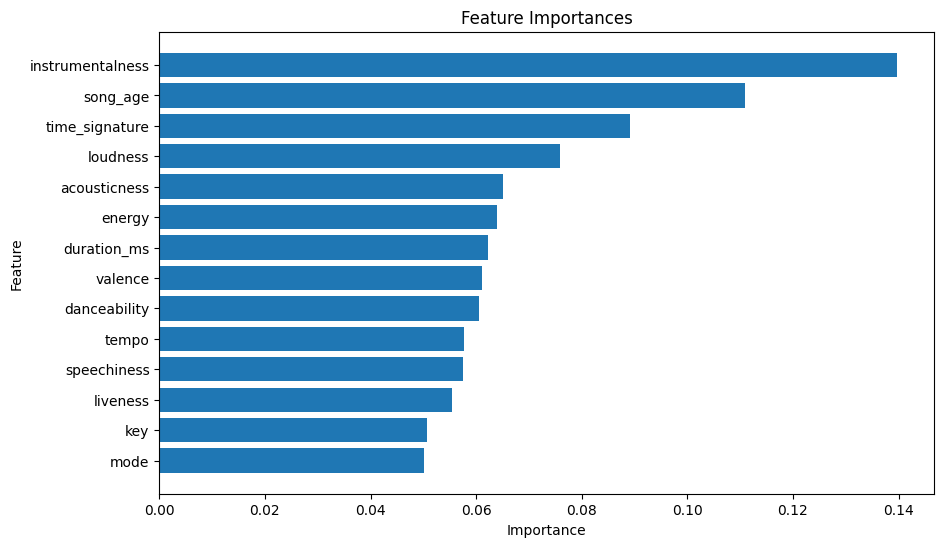

In [41]:
feature_importances = model.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [42]:
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from datetime import datetime

df = pd.read_csv('train.csv')
kaggle_data = pd.read_csv('test.csv')

df["track_album_release_date"] = pd.to_datetime(df["track_album_release_date"], errors='coerce')
df["song_age"] = datetime.now().year - df["track_album_release_date"].dt.year
df = df.drop(columns=["track_href", "uri", "analysis_url", "type", "track_album_release_date", "id"])
df.dropna(inplace=True)
df['Popularity_Type'] = df['Popularity_Type'].map({'High': 1, 'Low': 0})
df['key'] = df['key'].apply(lambda x: 1 if x >= 6 else 0)
df['time_signature'] = df['time_signature'].map({3: 0, 1: 0, 5: 1, 4: 1})

X = df.drop(columns=["Popularity_Type"])
y = df["Popularity_Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'gamma': trial.suggest_loguniform('gamma', 0.0001, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1.0),
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'objective': 'binary:logistic'
    }
    
    model = xgb.XGBClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Parameters:", best_params)

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Optimized ROC AUC: {roc_auc:.4f}")


[I 2025-02-28 11:04:01,645] A new study created in memory with name: no-name-1ee91206-2281-4fe3-9fe0-e2671d3038e2
/var/folders/rp/bfvqbqb10n15kqflg0nf5t_40000gn/T/ipykernel_20588/3172914413.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/var/folders/rp/bfvqbqb10n15kqflg0nf5t_40000gn/T/ipykernel_20588/3172914413.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.0001, 1),
/var/folders/rp/bfvqbqb10n15kqflg0nf5t_40000gn/T/ipykernel_20588/3172914413.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6

Best Parameters: {'learning_rate': 0.005472704978576667, 'n_estimators': 879, 'max_depth': 13, 'gamma': 0.0657862856854086, 'subsample': 0.6860788406941527, 'colsample_bytree': 0.8826277658672258, 'reg_alpha': 0.00025055468827209025, 'reg_lambda': 0.052763498854853146}
Optimized ROC AUC: 0.8151


# Submission Data Generation

In [43]:
kaggle_data = pd.read_csv('test.csv')
kaggle_data["track_album_release_date"] = pd.to_datetime(kaggle_data["track_album_release_date"], errors='coerce')
kaggle_data["song_age"] = datetime.now().year - kaggle_data["track_album_release_date"].dt.year
kaggle_data = kaggle_data.drop(columns=["track_href", "uri", "analysis_url", "type", "track_album_release_date"])
kaggle_data["key"] = kaggle_data["key"].apply(lambda x: 1 if x >= 6 else 0)
kaggle_data["time_signature"] = kaggle_data["time_signature"].map({3: 0, 1: 0, 5: 1, 4: 1})



kaggle_ids = kaggle_data["ID"]
kaggle_data = kaggle_data.drop(columns=["ID"])
kaggle_predictions = model.predict_proba(kaggle_data)[:, 1]

submission = pd.DataFrame({
    "ID": kaggle_ids,
    "Popularity_Type": kaggle_predictions
})
submission.to_csv("submission.csv", index=False)

print("Submission file 'submission.csv' generated successfully!")

Submission file 'submission.csv' generated successfully!
